In [53]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import one_hot
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import difflib
import nltk
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('brown')
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
stop = set(stopwords.words('english')) - {'no', 'not','never',"don't",'never','nor'}
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
from textblob import TextBlob

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/myleskornfeld/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/myleskornfeld/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/myleskornfeld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
print(stop)

{'these', 'did', 'while', 'shouldn', 'only', "doesn't", "haven't", 'was', 'to', 'we', 'its', 'some', 'there', 'the', 'y', 'has', 'but', 'yourself', "weren't", 'have', 'until', 'why', 'haven', 'where', 'other', 'each', 'hasn', 'i', "isn't", 'hadn', 'more', 'very', 'into', 'couldn', 'needn', 'her', 's', "you'll", "wouldn't", 'their', 'having', 'they', 'out', 'are', 've', "shouldn't", 'on', 'so', 'do', 'ours', 'am', 'that', 'above', 'any', 'themselves', 'again', 'this', 'from', 'wouldn', 'between', 'our', 'm', 'itself', 'when', 'weren', 'through', 'ma', "should've", "won't", "you've", "you're", 'up', 're', 'himself', 'mightn', "hasn't", 'down', 'should', 'before', 'him', 'his', 'all', 'it', "needn't", "mightn't", 'didn', 'be', 'were', 'had', 'can', 'those', 'after', 'below', 'over', "that'll", 'here', 'isn', 'both', 'about', "aren't", 'aren', 'how', 'a', 'with', 'doing', 'yours', 'for', 'just', 'whom', "hadn't", 'an', "you'd", 't', "shan't", 'own', 'shan', 'then', 'doesn', 'too', "mustn't

In [55]:
df_train = pd.read_csv('../training.1600000.processed.noemoticon.csv',encoding='latin-1')
df_test = pd.read_csv('../testdata.manual.2009.06.14.csv',encoding='latin-1')
df_test = df_test[df_test['sentiment']!=2]

In [56]:
df_train[(df_train['text'].str.contains(r'no|not|never|didnt',regex=True))&(df_train['sentiment']==0)].count()

sentiment    217486
user_id      217486
date         217486
query        217486
user         217486
text         217486
dtype: int64

In [57]:
df_train[(df_train['text'].str.contains(r'no|not|never|didnt|nor',regex=True))&(df_train['sentiment']==2)].count()

sentiment    0
user_id      0
date         0
query        0
user         0
text         0
dtype: int64

In [58]:
df_train[(df_train['text'].str.contains(r'no|not|never|didnt',regex=True))&(df_train['sentiment']==4)].count()

sentiment    144569
user_id      144569
date         144569
query        144569
user         144569
text         144569
dtype: int64

In [59]:
df_concat = pd.concat([df_train,df_test],axis=0)
df_concat.head()

,sentiment,user_id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Because of the imbalance in the testing data, i will combine the testing adn training and then do an 80/20 split

In [60]:
df_neg = df_concat[df_concat['text'].str.contains(r'no|not|never|didnt|never',regex=True)]
df_neg = df_neg.reset_index()
df_neg.head()

,index,sentiment,user_id,date,query,user,text
0,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
1,5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
2,7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
3,8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
4,10,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it's snowing


In [61]:
df_neg['text'] = df_neg['text'].str.lower()
df_neg['text'] = df_neg['text'].apply(lambda x: ' '.join([word for word in x.split() if '@' not in word]))
df_neg['text'] = df_neg['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_neg['text'] = df_neg['text'].str.replace(r'[^\w\s]','',regex=True)
df_neg.head()

,index,sentiment,user_id,date,query,user,text
0,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no not behaving all im mad here cant see there
1,5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not whole crew
2,7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time no see yes rains bit only bit lo...
3,8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope
4,10,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break plain city snowing


<AxesSubplot:>

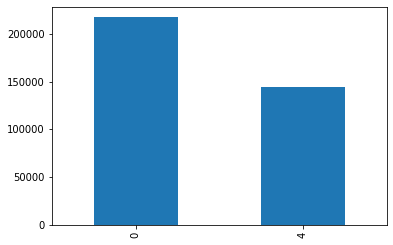

In [62]:
df_neg['sentiment'].value_counts(sort=False).plot.bar()

In [119]:
df_neg[['text']]['text'].str.count(' ').head()+1

0    10
1     3
2    18
3     1
4     5
Name: text, dtype: int64

In [118]:
df_neg['text'].iloc[0]

'no not behaving all im mad here cant see there'

Remove outliers

count    362116.000000
mean          9.397431
std           4.068642
min           0.000000
25%           6.000000
50%           9.000000
75%          12.000000
max          29.000000
Name: text, dtype: float64

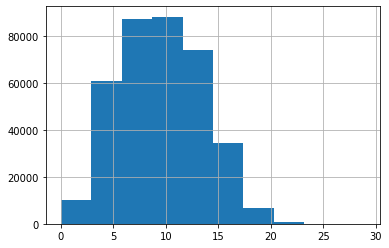

In [122]:
# df_neg['text'].str.split().apply(len).value_counts().head()
df_neg['text'].apply(lambda n: len(n.split())).hist()
df_neg['text'].apply(lambda n: len(n.split())).describe()

In [125]:
df_neg = df_neg[df_neg['text'].str.count(" ") >= 2]

In [134]:
vocab_size = 5000
max_length = df_neg['text'].apply(lambda n: len(n.split())).max()

myTokenizer = Tokenizer(num_words=vocab_size)
myTokenizer.fit_on_texts(df_concat['text'])
#print(myTokenizer.word_index)
sequences = myTokenizer.texts_to_sequences(df_neg['text'])
padded = pad_sequences(sequences, maxlen=max_length, padding="post")
#padded = pad_sequences(sequences, maxlen=20, padding="post")

len(padded)

352280

In [135]:
myTokenizer.word_index

{'i': 1,
 'to': 2,
 'the': 3,
 'a': 4,
 'my': 5,
 'and': 6,
 'you': 7,
 'is': 8,
 'it': 9,
 'in': 10,
 'for': 11,
 'of': 12,
 'on': 13,
 'me': 14,
 'so': 15,
 'have': 16,
 'that': 17,
 'but': 18,
 "i'm": 19,
 'just': 20,
 'with': 21,
 'be': 22,
 'at': 23,
 'not': 24,
 'was': 25,
 'this': 26,
 'now': 27,
 'good': 28,
 'up': 29,
 'day': 30,
 'out': 31,
 'all': 32,
 'get': 33,
 'like': 34,
 'are': 35,
 'no': 36,
 'go': 37,
 'quot': 38,
 'http': 39,
 'today': 40,
 'do': 41,
 "it's": 42,
 'too': 43,
 'your': 44,
 'work': 45,
 'love': 46,
 'going': 47,
 'got': 48,
 'lol': 49,
 'time': 50,
 'back': 51,
 'from': 52,
 'u': 53,
 'one': 54,
 'what': 55,
 'com': 56,
 'will': 57,
 'im': 58,
 'know': 59,
 'we': 60,
 'about': 61,
 'am': 62,
 'really': 63,
 "don't": 64,
 'amp': 65,
 'had': 66,
 'can': 67,
 'see': 68,
 "can't": 69,
 'some': 70,
 'its': 71,
 'if': 72,
 'still': 73,
 '2': 74,
 'well': 75,
 'night': 76,
 'new': 77,
 'want': 78,
 'how': 79,
 'think': 80,
 'home': 81,
 'thanks': 82,
 'oh': 

In [136]:
df_neg.head()

,index,sentiment,user_id,date,query,user,text
0,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no not behaving all im mad here cant see there
1,5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not whole crew
2,7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time no see yes rains bit only bit lo...
4,10,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break plain city snowing
5,13,0,1467812771,Mon Apr 06 22:20:19 PDT 2009,NO_QUERY,robrobbierobert,counts idk either never talk anymore


In [137]:
df_final = df_neg.join(pd.DataFrame(padded))

In [138]:
df_final.head()

,index,sentiment,user_id,date,query,user,text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no not behaving all im mad here cant see there,36.0,24.0,32.0,58.0,617.0,91.0,171.0,68.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,not whole crew,24.0,450.0,2247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time no see yes rains bit only bit lo...,157.0,172.0,50.0,36.0,68.0,160.0,2765.0,131.0,115.0,131.0,49.0,58.0,549.0,82.0,1786.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break plain city snowing,4904.0,857.0,488.0,168.0,346.0,417.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,13,0,1467812771,Mon Apr 06 22:20:19 PDT 2009,NO_QUERY,robrobbierobert,counts idk either never talk anymore,177.0,3934.0,24.0,63.0,133.0,3957.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
df_data = df_final.drop(['index','user_id','date','query','user','text'],axis=1)
df_data.head()

,sentiment,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,0,36.0,24.0,32.0,58.0,617.0,91.0,171.0,68.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,24.0,450.0,2247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,157.0,172.0,50.0,36.0,68.0,160.0,2765.0,131.0,115.0,131.0,49.0,58.0,549.0,82.0,1786.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4904.0,857.0,488.0,168.0,346.0,417.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,177.0,3934.0,24.0,63.0,133.0,3957.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
y = df_data['sentiment']
X = df_data.drop('sentiment',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

gridsearch on vocab size, config of layers, embedding dimensions, learning rate, embedding initializers, regularizers, constraints<br>
figure out what the ball park is with vocab size first, then finetune with gridsearch

In [22]:
def determine_lr(model, name, guess):
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: guess * 10**(epoch/15))
    optimizer = tf.keras.optimizers.SGD(lr=guess, momentum=0.9) #Stochastic gradient descent optimizer
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=3, callbacks = lr_schedule)
    plt.semilogx(history.history["lr"], history.history["loss"])
    plt.xlabel("Learning Rate (log)")
    plt.ylabel("Loss")
    plt.title("Learning Rate Determination "+name)
    plt.show()

#Produces a summary of the model and returns the history
def run_model(model, lrate):
    optimizer = tf.keras.optimizers.SGD(lr=lrate, momentum=0.9) #Stochastic gradient descent optimizer
    model.compile(optimizer = 'adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    print('data is compiled')
    history = model.fit(x=X_train, y=y_train, epochs=epoch_num, validation_data=(X_test, y_test))
    model.summary()
    return history

Epoch 1/3


2023-01-19 22:19:49.347721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-19 22:19:49.559594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-19 22:19:49.570321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-19 22:19:49.757566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/9053 [..............................] - ETA: 3:13:54 - loss: 0.6806 - accuracy: 0.0000e+00

2023-01-19 22:19:49.774909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9053/9053 [==============================] - 241s 27ms/step - loss: 0.6211 - accuracy: 0.0014 - lr: 1.0000e-06
Epoch 2/3
9053/9053 [==============================] - 243s 27ms/step - loss: 0.4619 - accuracy: 0.0000e+00 - lr: 1.1659e-06
Epoch 3/3
9053/9053 [==============================] - 242s 27ms/step - loss: 0.1159 - accuracy: 0.0000e+00 - lr: 1.3594e-06


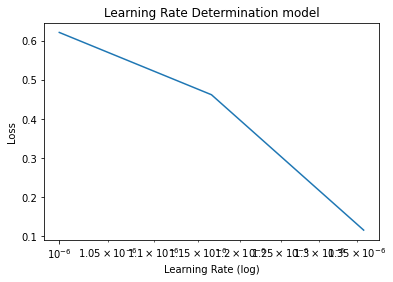

In [25]:
determine_lr(model, "model", 1e-6)

In [143]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    #tf.keras.layers.Dense(100, activation='relu'),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences = True)),
    tf.keras.layers.SimpleRNN(100, return_sequences = True),
    tf.keras.layers.SimpleRNN(100),
#     tf.keras.layers.Bidirectional(tf.keras.layers.RNN(embedding_dim)),
#     tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

num_epochs = 3
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = num_epochs, validation_data=(X_test, y_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 29, 16)            80000     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 29, 100)           11700     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 111,901
Trainable params: 111,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3


2023-01-22 16:03:39.364630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  12/8807 [..............................] - ETA: 1:57:13 - loss: -3.5050 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [24]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    #tf.keras.layers.Dense(100, activation='relu'),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

num_epochs = 3
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = num_epochs, validation_data=(X_test, y_test))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 16)            80000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 84,429
Trainable params: 84,429
Non-trainable params: 0
_________________________________________________________________


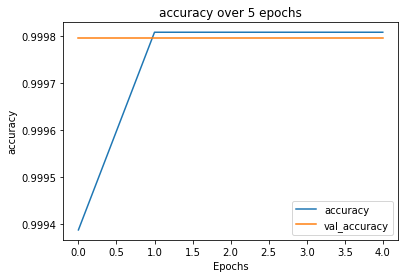

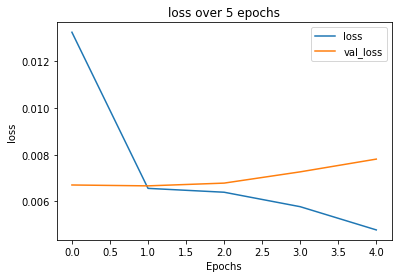

In [165]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title(string + " over " + str(num_epochs) + " epochs")
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")